In [1]:
import logging
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from src.simulation import *
from src.rl import *
from stable_baselines3.common.env_checker import check_env

logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [2]:
complete_series_csv = '../data/complete_series.csv'
df = pd.read_csv(complete_series_csv, parse_dates=['timestamp'])
prod_sim = EnergySim(max_step=7200, power_series=df.production_w)
cons_sim = EnergySim(max_step=6000, power_series=df.consumption_w, energy_type="consumption")
battery_wear_rate = 0
batt_sim = BatterySim(
    max_charge_rate=5000,
    max_discharge_rate=5000,
    capacity=10000,
    battery_wear_rate=battery_wear_rate,
    current_charge=10000
)
grid_sim = GridSim(
    feed_in_max=3500,
    feed_in_min=0,
    voltage_max=250,
    voltage_min=230,
    max_taken_from=6000,
    energy_price_sell=.1 / 1000,
    energy_price_buy=.4 / 1000,
    voltage_series=df.grid_voltage
)

inverter_sim = InverterSim(
    prod_sim=prod_sim,
    cons_sim=cons_sim,
    batt_sim=batt_sim,
    grid_sim=grid_sim,
    timestamps=df.timestamp.to_list(),
)
env = InverterEnv(inverter_sim, week)

6.5=6.5-0.0-0.0


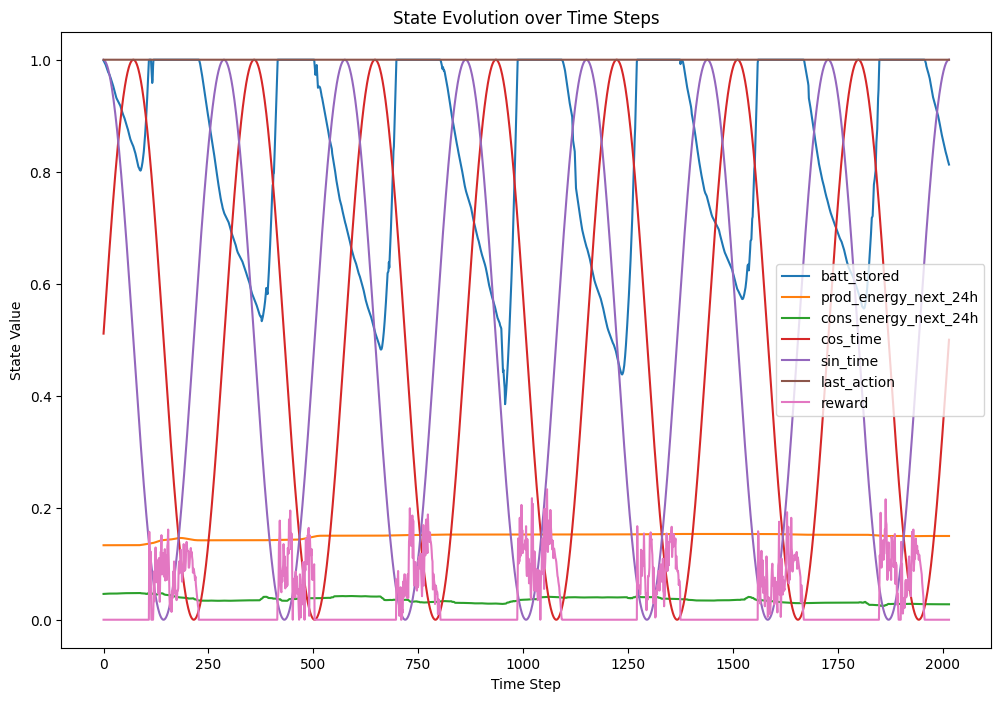

5.2=14.1-8.9-0.0


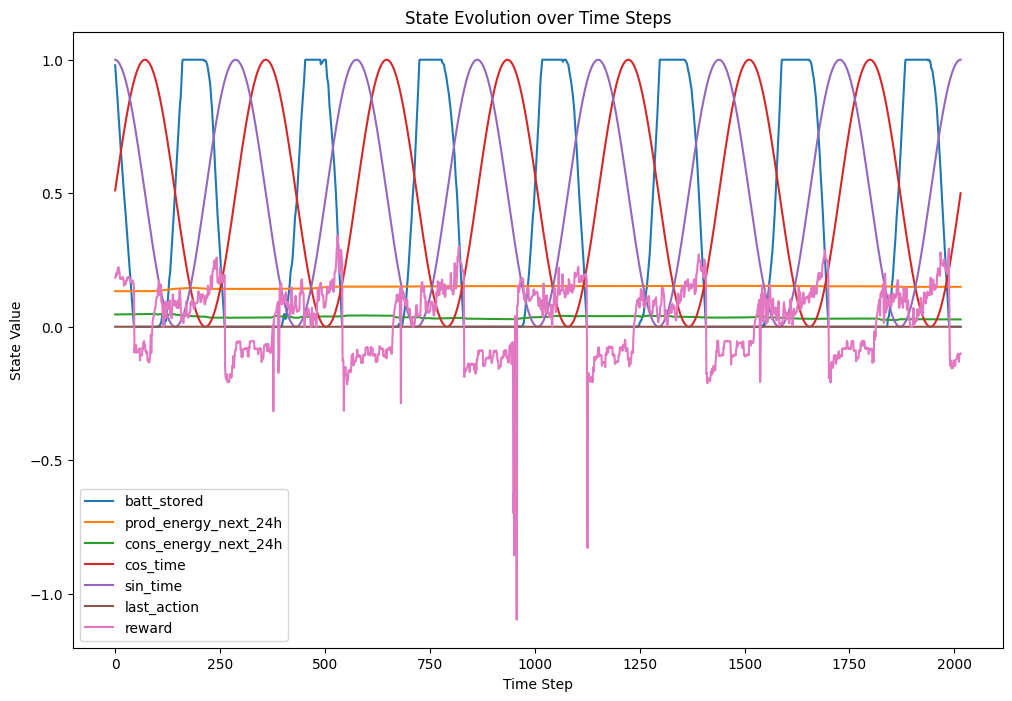

10.5=11.2-0.7-0.0


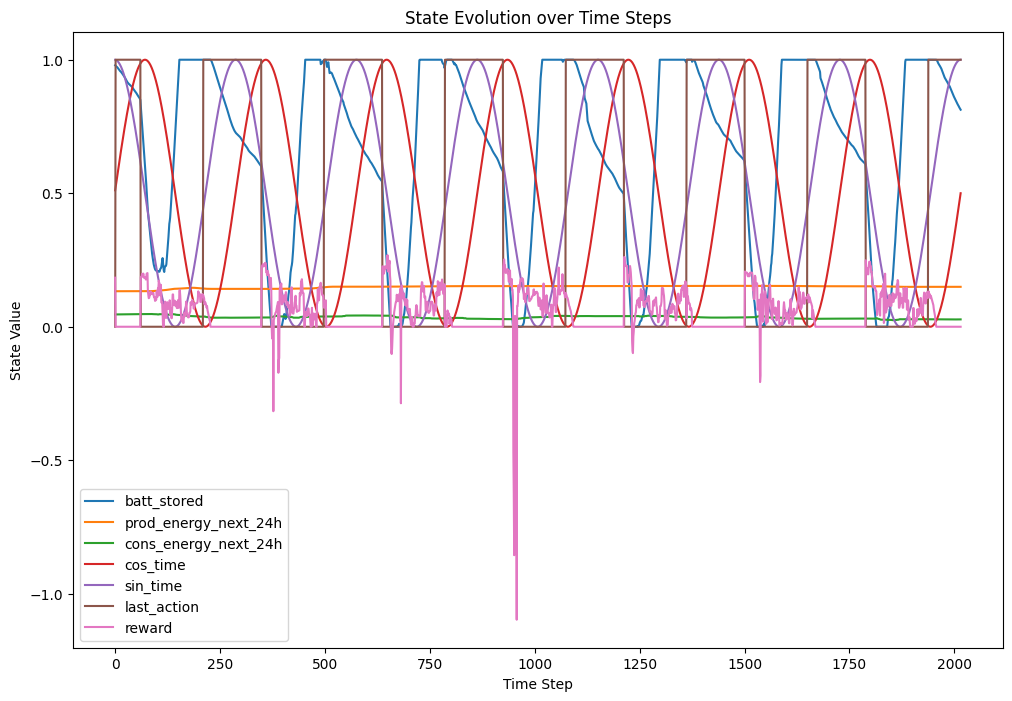

In [3]:
env.max_steps = week
to_show = [
    # "prod_energy",
    # "cons_energy",
    # "batt_charge_rate",
    # "batt_discharge_rate",
    "batt_stored",
    # "grid_feed_to",
    # "grid_taken_from",
    # "prod_energy_last_24h",
    # "cons_energy_last_24h",
    "prod_energy_next_24h",
    "cons_energy_next_24h",
    # "prod_energy_following_24h",
    # "cons_energy_following_24h",
    "cos_time",
    "sin_time",
    'last_action',
    'reward',
    # 'reward_energy_sold',
    # 'penalty_energy_purchase',
    # 'penalty_battery_wear'
]
for model in [ConservativeModel(), GreedyModel(), SimpleModel(60, 210)]:
    test_plot(env, model, env.max_steps, to_show)

In [21]:

check_env(env)
train_env = env
logs_ = "../logs/"
best_model_save_path = f"{logs_}best_model"
log_path = f"{logs_}results"
latest_model_path = f"{logs_}ppo_inverter"
best_model_path = f"{logs_}best_model/best_model"

eval_callback = EvalCallback(
    train_env,
    best_model_save_path=best_model_save_path,
    log_path=log_path,
    eval_freq=full_period * 5,
    deterministic=True,
    render=False,
    verbose=1
)

In [8]:
trained_model = PPO(
    "MlpPolicy",
    train_env,
    verbose=1,
    ent_coef=0.01,
    learning_rate=0.003,
    batch_size=2048,
)
eval_callback.eval_freq = train_env.max_steps * 5
trained_model.learn(
    total_timesteps=train_env.max_steps * 1000,
    callback=eval_callback
)
trained_model.save(
    latest_model_path
)

In [ ]:
train_env.max_steps = month
trained_model = PPO.load(
    best_model_path,
    env=train_env,
    verbose=0
)
eval_callback.eval_freq = train_env.max_steps * 5
trained_model.learn(
    total_timesteps=train_env.max_steps * 5 * 20,
    callback=eval_callback
)
trained_model.save(
    latest_model_path
)

In [25]:
train_env.max_steps = full_period

In [37]:
trained_model = PPO.load(
    best_model_path,
    env=train_env,
    verbose=0
)
eval_callback.eval_freq = train_env.max_steps * 5
trained_model.learn(
    total_timesteps=train_env.max_steps * 5 * 20,
    callback=eval_callback
)
trained_model.save(latest_model_path)

/home/emanuele/IdeaProjects/EnergyManagementRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=38784, episode_reward=248.24 +/- 0.00
Episode length: 40321.00 +/- 0.00
New best mean reward!
Eval num_timesteps=240384, episode_reward=253.31 +/- 0.00
Episode length: 40321.00 +/- 0.00
New best mean reward!
Eval num_timesteps=441984, episode_reward=242.03 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=643584, episode_reward=249.27 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=845184, episode_reward=253.83 +/- 0.00
Episode length: 40321.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1046784, episode_reward=238.60 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=1248384, episode_reward=209.65 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=1449984, episode_reward=231.06 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=1651584, episode_reward=234.18 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_timesteps=1853184, episode_reward=231.63 +/- 0.00
Episode length: 40321.00 +/- 0.00
Eval num_t

KeyboardInterrupt: 

In [44]:
trained_model.save("../logs/ppo_inverter_1")

1.0=1.0-0.0-0.0


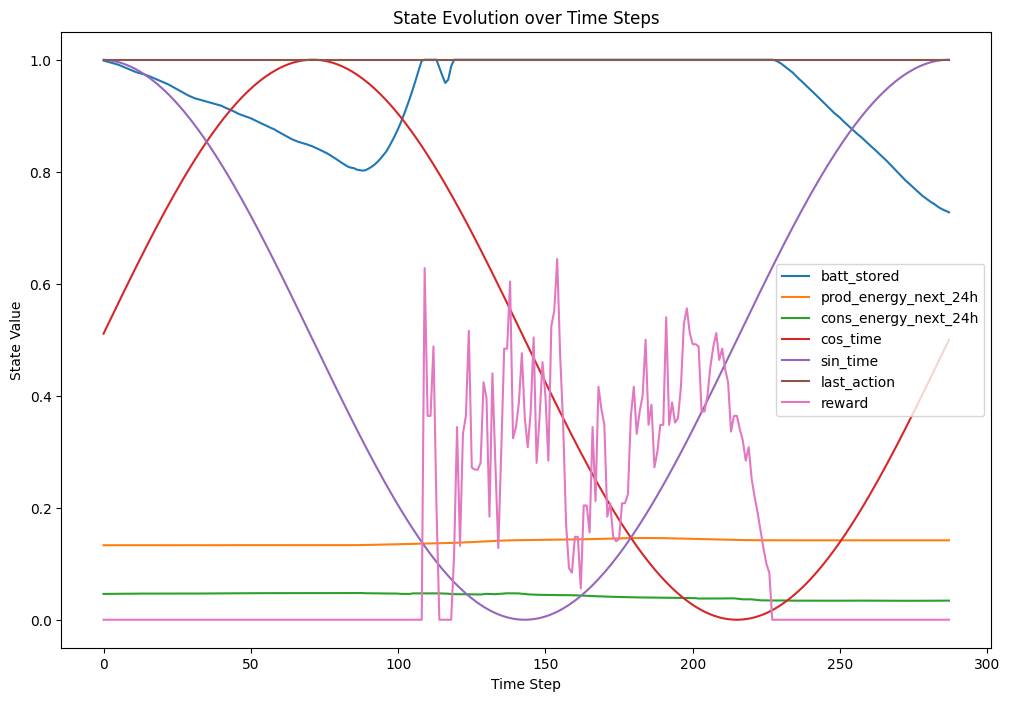

1.8=2.6-0.8-0.0


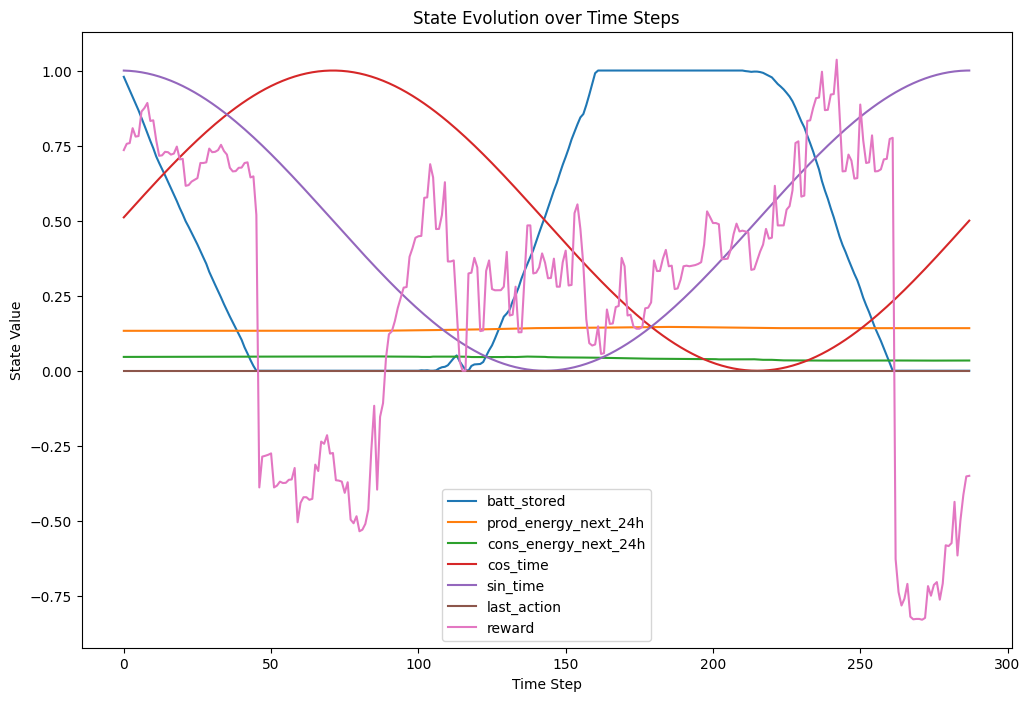

1.6=1.6-0.0-0.0


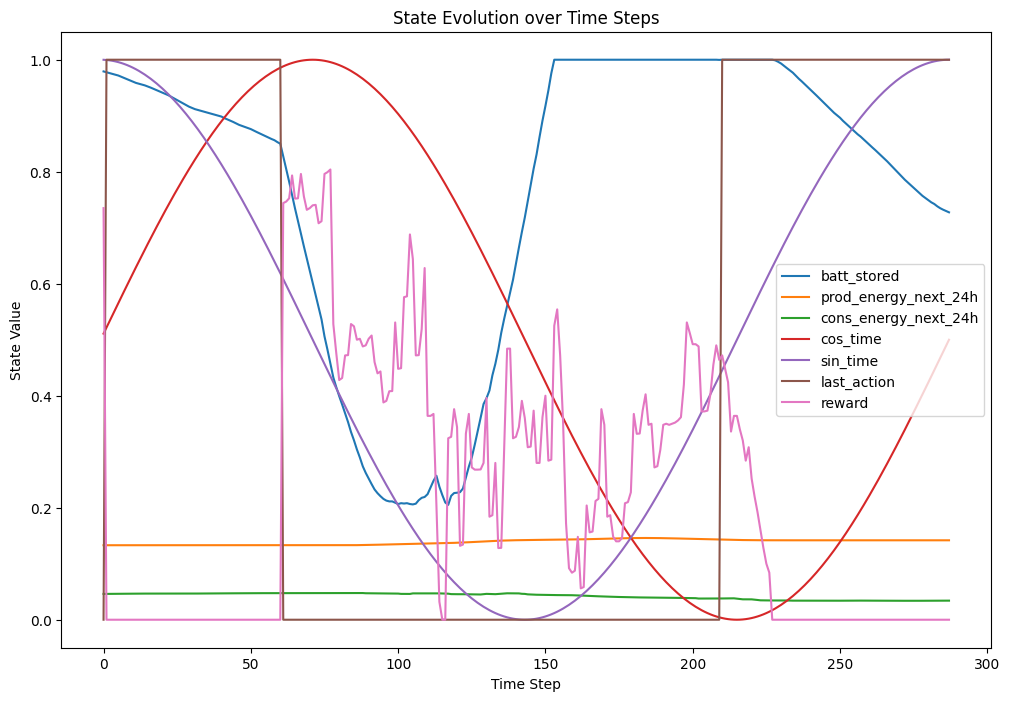

1.9=1.9-0.1-0.0


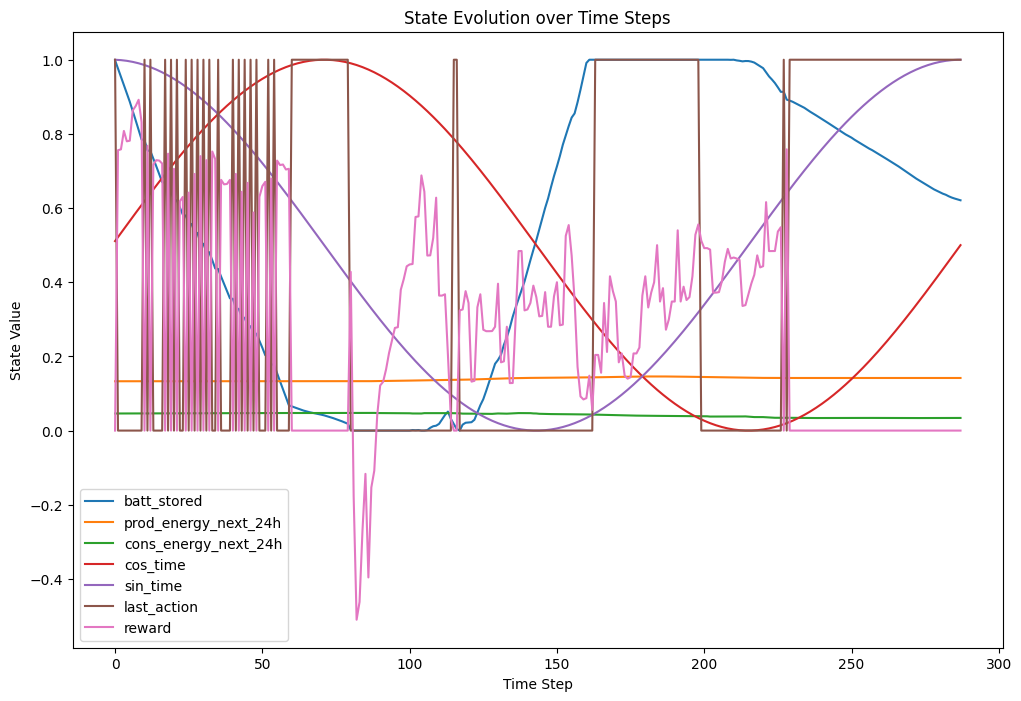

In [23]:
trained_model = PPO.load(
    best_model_path,
    env=train_env
)
for model_to_test in [
    ConservativeModel(),
    GreedyModel(),
    SimpleModel(),
    trained_model
]:
    test_plot(
        train_env,
        model_to_test,
        day,
        to_show
    )